# Objectives: A classification data set with skewed class proportions is called imbalanced. Classes that make up a large proportion of the data set are called majority classes. Those that make up a smaller proportion are minority classes.An effective way to handle imbalanced data is to downsample and upweight the majority class. Let's start by defining those two new terms:

Downsampling (in this context) means training on a disproportionately low subset of the majority class examples.
Upweighting means adding an example weight to the downsampled class equal to the factor by which you downsampled.
-
-

### Getting Started:
- Colab notebooks consist of text cells (like this one) and program code cells, like the one shown below. Code cells are executed by typing the Cmd+Enter keys (or Ctrl-Enter). You can also execute a code cell by mousing over the [ ] symbol in the upper left hand side of the code cell---when you hover over it it will turn into a "play" button, and clicking the play button will execute the code cell. You can find other options for executing groups of cells in the "Runtime" menu above.

- Start by executing the code cell below (the one that begins with the line import pandas as pd). This loads ("imports") the required software modules that will be used in the assignment.
## Loading Python Libraries

In [1]:
#load the packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,KBinsDiscretizer,OneHotEncoder,StandardScaler
 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
 
from sklearn.metrics import confusion_matrix,recall_score
from sklearn.compose import ColumnTransformer
 
from scipy import stats
 
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Take a moment to look at this code block:
- import loads a module
- import ... as allows you to assign a short alias to the module
- from ... import loads a small portion of a module
- observe that the import, as and from keywords are color coded purple.
indicates a comment (observe that all of the text following the # is color coded green). This text is not interpreted by the computer, and its goal is to provide the human with some information about what is happening.<BR><BR>
What do each of these program modules do? You can think of them as being like a library of books that accomplish program tasks. In general, they can be quite complicated. In most cases, you will never learn all of the functionality of a module, and will have to use the documentation to help you determine the relevant parts for solving your problem. It is useful to have a general sense of the types of tasks that each of modules do, so that you can find the appropriate functionality.

- `pandas` is a library for handling datasets
- `numpy` and `scipy` are libraries for mathematical and scientific computing
- `matplotlib` and `plotly` are libraries for data visualization
- `sklearn` and `imblearn` are libraries for machine learning

Importing file:

In [2]:
from google.colab import files
uploaded = files.upload()

Saving ORGANIC.xlsx to ORGANIC.xlsx


In [4]:
import io
df = pd.read_excel(io.BytesIO(uploaded['ORGANIC.xlsx']))
df.head()

,shelf,book,page,λ,n,k
0,organic,(C2ClF3)n - polychlorotrifluoroethylene,Smith,0.0900,1.196,0.6096
1,organic,(C2ClF3)n - polychlorotrifluoroethylene,Smith,0.0900,1.209,0.6501
2,organic,(C2ClF3)n - polychlorotrifluoroethylene,Smith,0.0900,1.228,0.7096
3,organic,(C2ClF3)n - polychlorotrifluoroethylene,Smith,0.0900,1.235,0.7315
4,organic,(C2ClF3)n - polychlorotrifluoroethylene,Smith,0.1012,1.417,0.4472


In [5]:
# Creating a copy so that our original remain intact.
new_df = df.copy()

## Exploring the dataset

In [6]:
df.shape

(252130, 6)

In [7]:
# Investigating all the elements within each feature
for column in df:
    unique_vals = np.unique(df[column].astype(str))
    nr_values = len(unique_vals)
    
    if nr_values < 36:
        print('The number of values for feature -  {} : {} -- {}'.format(column, nr_values, unique_vals))
    else:
        print('The number of values for feature {} : {}'.format(column, nr_values))

The number of values for feature -  shelf : 1 -- ['organic']
The number of values for feature book : 61
The number of values for feature page : 59
The number of values for feature λ : 54358
The number of values for feature n : 41463
The number of values for feature k : 195870


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252130 entries, 0 to 252129
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   shelf   252130 non-null  object 
 1   book    252130 non-null  object 
 2   page    252129 non-null  object 
 3   λ       252129 non-null  float64
 4   n       245286 non-null  float64
 5   k       242239 non-null  float64
dtypes: float64(3), object(3)
memory usage: 11.5+ MB


In [9]:
#filling missing values in k with '0'
df['k'].fillna(0,inplace=True)
# Dropping all the null values from n
df.dropna(axis=0,inplace=True)   

We don't require 'Shelf' and 'Page' for the training and texting purpose.
Dropping "Shelf" and "Page"

In [10]:
df.drop(['shelf','page'],axis=1,inplace=True)

In [11]:
df.shape

(245286, 4)

We are down from 252130 rows to 245286, and from 6 columns to 4.<br>
We also need to catagories Wavelength into "UV", "visible_light", "near_IR", "IR_rays" and "Far_IR_Rays", based on the range mentioned below.

# Shuffling

In [12]:
display(df.head())
df = df.sample(frac=1).reset_index(drop= True)
df.head()

,book,λ,n,k
0,(C2ClF3)n - polychlorotrifluoroethylene,0.0900,1.196,0.6096
1,(C2ClF3)n - polychlorotrifluoroethylene,0.0900,1.209,0.6501
2,(C2ClF3)n - polychlorotrifluoroethylene,0.0900,1.228,0.7096
3,(C2ClF3)n - polychlorotrifluoroethylene,0.0900,1.235,0.7315
4,(C2ClF3)n - polychlorotrifluoroethylene,0.1012,1.417,0.4472


,book,λ,n,k
0,diisopropylaminoethanol,19.02900,1.45292,0.015923
1,benzene,1.70374,1.47769,0.000088
2,dimethyl_methylphosphonate,3.48866,1.39587,0.007809
3,polydimethylsiloxane,0.43500,1.42963,0.000000
4,oxathiane,3.29750,1.47285,0.001231


In [13]:
# Creating a new Column for the wavelength catagory:
df['λ_binned'] = pd.cut(df['λ'], [-np.inf,0.4,0.75,1.5,4.0,np.inf],
                            labels=['UV','visible_light','near_IR','IR_rays','Far_IR_Rays'])
df.head()

,book,λ,n,k,λ_binned
0,diisopropylaminoethanol,19.02900,1.45292,0.015923,Far_IR_Rays
1,benzene,1.70374,1.47769,0.000088,IR_rays
2,dimethyl_methylphosphonate,3.48866,1.39587,0.007809,IR_rays
3,polydimethylsiloxane,0.43500,1.42963,0.000000,visible_light
4,oxathiane,3.29750,1.47285,0.001231,IR_rays


In [14]:
# Distribution of datapoints amongst different wavelengths
df.λ_binned.value_counts()

IR_rays          135408
Far_IR_Rays       66678
near_IR           35446
visible_light      5980
UV                 1774
Name: λ_binned, dtype: int64

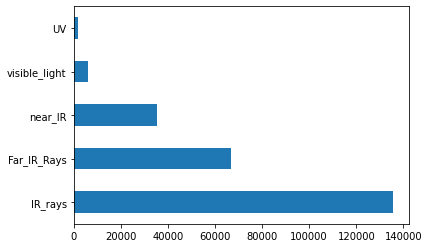

In [15]:
df.λ_binned.value_counts().plot(kind='barh')
plt.show()

### There is very high class imbalance - We can see that uv and visible light are having very few samples, compared to the next three.

- Dividing the dataframe into two parts : `df_minor` and `df_major`.
-`df_minor` will have "UV" and "Visible Light".
- `df_major` will have "near_IR", "IR_rays" and "Far_IR_Rays". 

In [16]:
df.shape

(245286, 5)

In [17]:
# Creating df_minor and df_major based on the wavelength category mensioned above
df_minor = df[ (df.λ_binned=='UV') | (df.λ_binned=='visible_light')]
df_major = df[df.λ_binned!='UV']
df_major = df_major[df.λ_binned!='visible_light']
df_major.λ_binned.unique()
print('Length of df_minor : {}\nLength of df_major : {} '.format(len(df_minor), len(df_major)))

Length of df_minor : 7754
Length of df_major : 237532 


- Downsampling `majority class` i.e. `df_major`
- Upsampling `minority class`, i.e. `df_minor`
- Combining the above two in `df_up_down_sampled`

In [18]:
from sklearn.utils import resample
#Downsample majority class
df_majority_downsampled = resample(df_major, 
                                 replace=False,    
                                 n_samples=150000,
                                 stratify = df_major['λ_binned'],
                                 random_state=42)
#Upsample minority class
df_minority_upsampled = resample(df_minor, 
                                 replace=True,     
                                 n_samples=60000,
                                 stratify = df_minor['λ_binned'],
                                 random_state=42)
# Combine minority class with df_majority_downsampled class
df_up_down_sampled = pd.concat([df_majority_downsampled, df_minority_upsampled],ignore_index=True)

In [19]:
# Final shape of the combined dataframe
print("Size of the new combined dataframe 'df_up_down_sampled' : ", end= "")
print(df_up_down_sampled.shape[0])

Size of the new combined dataframe 'df_up_down_sampled' : 210000


In [20]:
# Distribution of datapoint amongst different Wavelength categories.
df_up_down_sampled.λ_binned.value_counts()

IR_rays          85509
visible_light    46273
Far_IR_Rays      42107
near_IR          22384
UV               13727
Name: λ_binned, dtype: int64

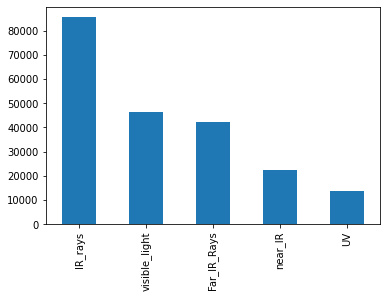

In [21]:
df_up_down_sampled.λ_binned.value_counts().plot(kind='bar')
plt.show()

In [22]:
df_up_down_sampled.head()

,book,λ,n,k,λ_binned
0,acetonitrile,3.52863,1.33485,0.000974,IR_rays
1,styrene,1.71654,1.51613,0.000063,IR_rays
2,oxathiane,1.70612,1.48842,0.000096,IR_rays
3,trichlorobenzene,2.59489,1.54654,0.000031,IR_rays
4,diisopropylaminoethanol,14.23570,1.45003,0.003183,Far_IR_Rays


## Splitting the modified Data
*Creating Input features (attributes) and Target Vectors for Training and testing the ML model.*

In [23]:
df_up_down_sampled.drop('λ',axis=1,inplace=True)
y = df_up_down_sampled['book']               # Target Vector
x = df_up_down_sampled.drop('book',axis=1)   # Input Features (attributes)

print('x shape: {}'.format(np.shape(x)[0]))
print('y shape: {}'.format(np.shape(y)[0]))

x shape: 210000
y shape: 210000


*`75%` data is for training and `25%` data is for testing.*

In [24]:
#split the data for training and testing
from sklearn.metrics import accuracy_score,classification_report
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.25,random_state=42,stratify=x.λ_binned)

In [25]:
print('Length of x_test : {}\nLength of y_test : {}\nLength of x_train : {}\nLength of y_train : {}'.format(len(x_test),  len(y_test), len(x_train), len(y_train)))

Length of x_test : 52500
Length of y_test : 52500
Length of x_train : 157500
Length of y_train : 157500


`λ_binned` is our Catagorical features, whereas, `n` and `k` are Numerical features.

In [26]:
cat_features = ['λ_binned']
numeric_features = ['n','k']

In [27]:
#preprocessing and training pipeline with our own bins

numeric_transformer = Pipeline(steps=[
                                      ('scaler', StandardScaler())
                                      ])

categorical_transformer = Pipeline(steps=[
                                          ('onehot',OneHotEncoder())
                                          ])

preprocessor = ColumnTransformer(
    transformers=[
                  ('numeric', numeric_transformer, numeric_features),   #apply the transformation
                  ('category',categorical_transformer,cat_features)
                  ]) 

pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('classifier',RandomForestClassifier(random_state=42))
           ])

## Model

In [28]:
# model
rf_model = pipeline.fit(x_train, y_train)
print (rf_model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['n', 'k']),
                                                 ('category',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['λ_binned'])])),
                ('classifier', RandomForestClassifier(random_state=42))])


In [29]:
# Training and testing Accuracy
print(f'Training accuracy {rf_model.score(x_train,y_train)}')
print(f'Test accuracy {rf_model.score(x_test,y_test)}')

Training accuracy 0.9787619047619047
Test accuracy 0.8692


## Cross Validation

In [31]:
from sklearn.model_selection import cross_val_score
cv_four = cross_val_score(rf_model, x, y, cv = 4, scoring = 'accuracy')
print(cv_four)
print('Mean:',cv_four.mean())

[0.77620952 0.86062857 0.87693333 0.72314286]
Mean: 0.8092285714285714


In [32]:
from sklearn.model_selection import cross_val_score
cv_five = cross_val_score(rf_model, x, y, cv = 5, scoring = 'accuracy')
print(cv_five)
print('Mean:',cv_five.mean())

[0.7557619  0.86071429 0.86595238 0.88428571 0.77071429]
Mean: 0.8274857142857142


In [33]:
UV = x_test[x_test.λ_binned== 'UV']
UV_y = y_test[x_test.λ_binned== 'UV']
Visible = x_test[x_test.λ_binned== "Visible"]
Visible_y = y_test[x_test.λ_binned == "Visible"]
Near_IR = x_test[x_test.λ_binned== 'Near_IR']
Near_IR_y = y_test[x_test.λ_binned== 'Near_IR']
IR = x_test[x_test.λ_binned== 'IR']
IR_y = y_test[x_test.λ_binned== 'IR']
Far_IR = x_test[x_test.λ_binned== 'Far_IR']
Far_IR_y = y_test[x_test.λ_binned== 'Far_IR']

### Precision, Recall, F1-Score of this model

In [34]:
y_pred = rf_model.predict(x_test)
print(len(y_pred), len(x_test))

52500 52500


In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

                                         precision    recall  f1-score   support

(C2ClF3)n - polychlorotrifluoroethylene       0.59      0.53      0.56        64
           (C6H12)n - polymethylpentene       0.00      0.00      0.00         4
                              Acetylene       1.00      1.00      1.00       184
                            Cyclohexane       1.00      1.00      1.00       900
                          Ethyl acetate       0.99      1.00      0.99       185
                               Ethylene       1.00      1.00      1.00       208
                                Heptane       1.00      0.99      1.00       594
                                 Hexane       1.00      1.00      1.00       828
                               Methanol       0.87      0.90      0.89      2817
                 Pentanol, amyl alcohol       0.99      0.99      0.99       146
                            acetic_acid       0.97      1.00      0.98       186
                           

#### Checking the accuracy catagory wise, for: `UV`, `Far_IR_Rays`, `IR_rays`, `near_IR`,`visible_light` , individually

### For Training Set :

In [36]:
# Here are the accuracies in the tabular format:
labls = ['UV','Far_IR_Rays','IR_rays',"near_IR",'visible_light']
tr_scores = []

for l in labls:
  train_x = x_train[x_train.λ_binned==l]
  train_y = y_train[x_train.λ_binned==l]
 
  tr_scores.append(rf_model.score(train_x,train_y))
for i in range(len(labls)):
    print(labls[i],":", tr_scores[i])

UV : 0.988052452646916
Far_IR_Rays : 0.9981633945535149
IR_rays : 0.9507889976922597
near_IR : 1.0
visible_light : 0.9997694856648898


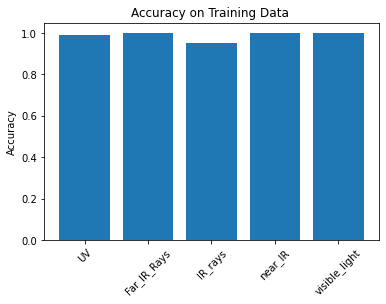

In [37]:
# Accuracy based on different wavelengths
plt.bar(labls,tr_scores)
plt.title('Accuracy on Training Data ')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

### For Test Set :

In [38]:
# Here are the accuracies in the tabular format:
labls = ['UV','Far_IR_Rays','IR_rays',"near_IR",'visible_light']
ts_scores = []

for l in labls:
  test_x = x_test[x_test.λ_binned==l]
  test_y = y_test[x_test.λ_binned==l]
 
  ts_scores.append(rf_model.score(test_x,test_y))
for i in range(len(labls)):
    print(labls[i],":", ts_scores[i])

UV : 0.9825174825174825
Far_IR_Rays : 0.7024793388429752
IR_rays : 0.8342611217663845
near_IR : 0.9801644031451037
visible_light : 0.9981846473029046


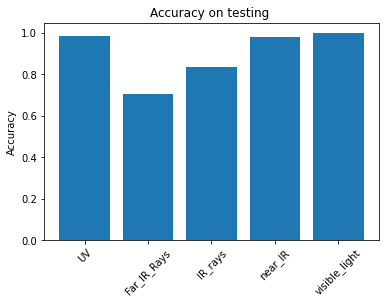

In [39]:
# Accuracy based on different wavelengths
plt.bar(labls,ts_scores)
plt.title('Accuracy on testing ')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

### Prediction on up-down sampled data

## Splitting the Raw Data
*Creating Input features (attributes) and Target Vectors for Training and testing the ML model.*

### Prediction Time:

In [40]:
pred = rf_model.predict(x_test)

In [41]:
# Predicting the Book, based on the the parameters:
def predict(l_binned,n,k,model):
  pred_df = pd.DataFrame({'λ_binned':[l_binned],
                         'n':[n],
                         'k':[k]})
  pred = model.predict(pred_df)
  return f'Book is {pred[0]}'

predict('UV',1,0,rf_model)

'Book is methane'

### Confusion Matrix

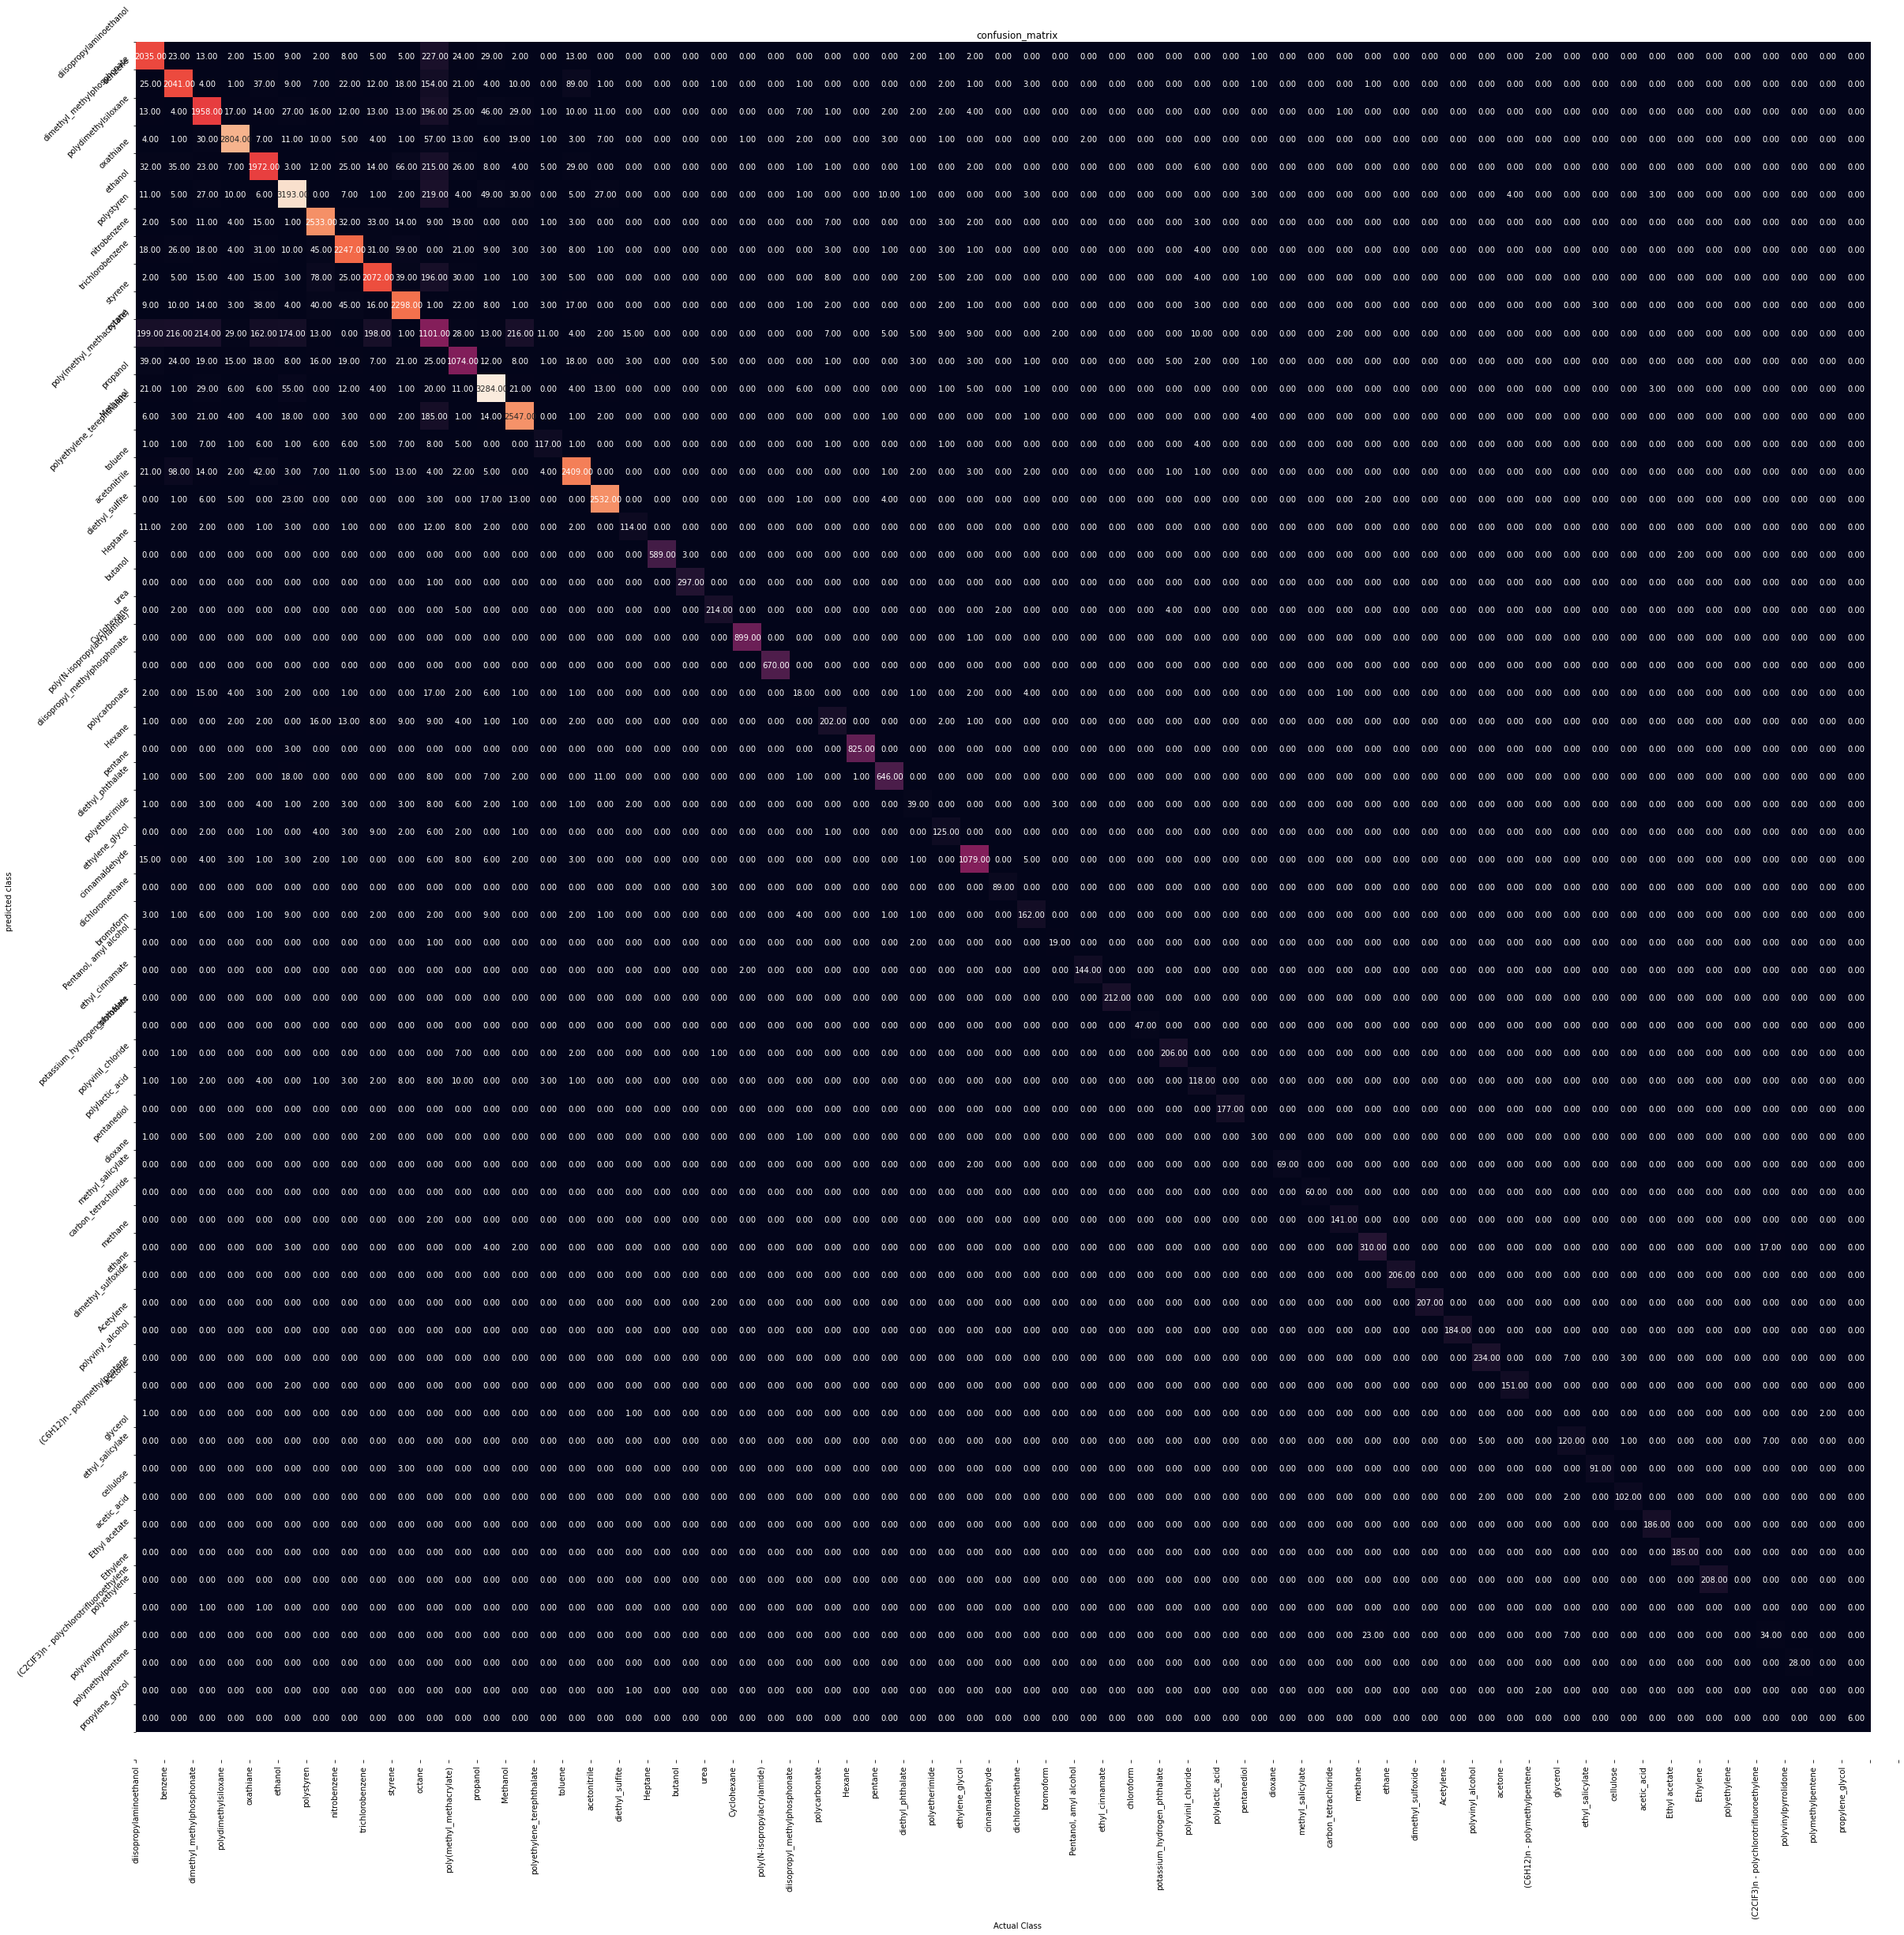

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(40,40))
cm = confusion_matrix(y_test,pred,labels=list(df.book.unique()))
sns.heatmap(cm,annot=True,fmt='.2f',cbar=False)
plt.xticks(range(0,63),labels=list(df.book.unique()),rotation=90)
plt.yticks(range(0,63),labels=list(df.book.unique()),rotation=45)
plt.title('confusion_matrix')         #checking the confusion matrix
plt.xlabel('Actual Class')
plt.ylabel('predicted class')
plt.show()

### Checking the accuracy on bases of the Wavelength Catagory:

In [43]:
# Creating test set based upon the category of Wavelength they belong to:
UV = x_test[x_test.λ_binned=='UV']
UV_y = y_test[x_test.λ_binned=='UV']
Near_IR = x_test[x_test.λ_binned=='near_IR']
Near_IR_y = y_test[x_test.λ_binned=='near_IR']
Far_IR = x_test[x_test.λ_binned=='Far_IR_Rays']
Far_IR_y = y_test[x_test.λ_binned=='Far_IR_Rays']
IR = x_test[x_test.λ_binned=='IR_rays']
IR_y = y_test[x_test.λ_binned=='IR_rays']
Visible = x_test[x_test.λ_binned=='visible_light']
Visible_y = y_test[x_test.λ_binned=='visible_light']

In [44]:
# Prediction 1: 
print(UV[10:19])
print('-'*90,end='\n\n')
print('Actual Class\n\n',UV_y[10:19])
print('-'*90,end='\n\n')
print('Predicted class\n\n',rf_model.predict(UV[10:19]))

               n             k λ_binned
156636  1.449725  0.000000e+00       UV
188463  1.450300  0.000000e+00       UV
183269  1.467900  6.378000e-07       UV
158822  1.392930  2.820350e-06       UV
186920  1.364521  0.000000e+00       UV
155216  1.393529  0.000000e+00       UV
151948  1.419930  0.000000e+00       UV
170486  1.397608  0.000000e+00       UV
162354  1.354063  0.000000e+00       UV
------------------------------------------------------------------------------------------

Actual Class

 156636             Cyclohexane
188463    polydimethylsiloxane
183269         ethylene_glycol
158822                 ethanol
186920                 pentane
155216                propanol
151948           Ethyl acetate
170486                propanol
162354                 pentane
Name: book, dtype: object
------------------------------------------------------------------------------------------

Predicted class

 ['Cyclohexane' 'polydimethylsiloxane' 'ethylene_glycol' 'ethanol'
 'pentane' '

We can see that the prediction matched the actual class perfectly. 
### Some more predictions :

In [45]:
def predict(l_binned,n,k,model):
  pred_df = pd.DataFrame({'λ_binned':[l_binned],
                         'n':[n],
                         'k':[k]})
  pred = model.predict(pred_df)
  return f'Book is {pred[0]}'

predict('UV',1.437401e+00,0.000000e+00,rf_model)

'Book is polydimethylsiloxane'

In [46]:
# Prediction 2:
print(Near_IR[10:19])
print('-'*90,end='\n\n')
print('Actual Class\n\n',Near_IR_y[10:19])
print('-'*90,end='\n\n')
print('Predicted class\n\n',rf_model.predict(Near_IR[10:19]))

               n         k λ_binned
144248  1.516190  0.000031  near_IR
18911   1.400940  0.000013  near_IR
83877   1.428400  0.000044  near_IR
119300  1.477800  0.000028  near_IR
5615    1.474560  0.000013  near_IR
145959  1.488940  0.000003  near_IR
66591   1.451001  0.000000  near_IR
66441   1.547460  0.000003  near_IR
58572   1.516230  0.000031  near_IR
------------------------------------------------------------------------------------------

Actual Class

 144248                       styrene
18911     dimethyl_methylphosphonate
83877        diisopropylaminoethanol
119300                       benzene
5615                         toluene
145959                     oxathiane
66591           carbon_tetrachloride
66441               trichlorobenzene
58572                        styrene
Name: book, dtype: object
------------------------------------------------------------------------------------------

Predicted class

 ['styrene' 'dimethyl_methylphosphonate' 'diisopropylaminoethanol

In [47]:
# near_IR, Prediction
def predict(l_binned,n,k,model):
  pred_df = pd.DataFrame({'λ_binned':[l_binned],
                         'n':[n],
                         'k':[k]})
  pred = model.predict(pred_df)
  return f'Book is {pred[0]}'

predict('near_IR',1.462147,0.000000,rf_model)

'Book is cellulose'

In [48]:
# Prediction 3: Far_IR
print(Far_IR[10:19])
print('-'*90,end='\n\n')
print('Actual Class\n\n',Far_IR_y[10:19])
print('-'*90,end='\n\n')
print('Predicted class\n\n',rf_model.predict(Far_IR[10:19]))

              n         k     λ_binned
148832  1.52600  0.009406  Far_IR_Rays
6099    1.33170  0.001540  Far_IR_Rays
40371   1.29205  0.101383  Far_IR_Rays
101443  1.54408  0.000037  Far_IR_Rays
101986  1.32820  0.003444  Far_IR_Rays
119371  1.50648  0.040221  Far_IR_Rays
69866   1.55479  0.000364  Far_IR_Rays
117532  1.51536  0.003040  Far_IR_Rays
116535  1.47431  0.000299  Far_IR_Rays
------------------------------------------------------------------------------------------

Actual Class

 148832    poly(methyl_methacrylate)
6099                   acetonitrile
40371              trichlorobenzene
101443             trichlorobenzene
101986                      ethanol
119371             trichlorobenzene
69866                    polystyren
117532                    oxathiane
116535                      toluene
Name: book, dtype: object
------------------------------------------------------------------------------------------

Predicted class

 ['poly(methyl_methacrylate)' 'acetonitrile'

In [49]:
# Prediction Far_IR_Rays
def predict(l_binned,n,k,model):
  pred_df = pd.DataFrame({'λ_binned':[l_binned],
                         'n':[n],
                         'k':[k]})
  pred = model.predict(pred_df)
  return f'Book is {pred[0]}'

predict('Far_IR_Rays',1.55675,0.003872,rf_model)

'Book is styrene'

In [50]:
# Prediction 4 : IR
print(IR[10:19])
print('-'*90,end='\n\n')
print('Actual Class\n\n',IR_y[10:19])
print('-'*90,end='\n\n')
print('Predicted class\n\n',rf_model.predict(IR[10:19]))

              n         k λ_binned
82464   1.39267  0.038262  IR_rays
1198    1.47732  0.000089  IR_rays
120364  1.51550  0.008329  IR_rays
457     1.40027  0.000033  IR_rays
115559  1.47725  0.000020  IR_rays
127263  1.51931  0.000108  IR_rays
10730   1.47409  0.000010  IR_rays
116756  1.39870  0.000038  IR_rays
105484  1.36135  0.000065  IR_rays
------------------------------------------------------------------------------------------

Actual Class

 82464                       propanol
1198                         benzene
120364                     oxathiane
457       dimethyl_methylphosphonate
115559                       benzene
127263                  nitrobenzene
10730                        toluene
116756    dimethyl_methylphosphonate
105484                      propanol
Name: book, dtype: object
------------------------------------------------------------------------------------------

Predicted class

 ['propanol' 'benzene' 'nitrobenzene' 'dimethyl_methylphosphonate'
 'benzen

In [51]:
# Prediction, based on the parameters 
def predict(l_binned,n,k,model):
  pred_df = pd.DataFrame({'λ_binned':[l_binned],
                         'n':[n],
                         'k':[k]})
  pred = model.predict(pred_df)
  return f'Book is {pred[0]}'

predict('IR_rays',1.47427,0.000013,rf_model)

'Book is toluene'

In [52]:
# Prediction 5 : Visible rays
print(Visible[10:19])
print('-'*90,end='\n\n')
print('Actual Class\n\n',Visible_y[10:19])
print('-'*90,end='\n\n')
print('Predicted class\n\n',rf_model.predict(Visible[10:19]))

               n    k       λ_binned
177678  1.393222  0.0  visible_light
198825  1.333447  0.0  visible_light
167513  1.339312  0.0  visible_light
158779  1.434000  0.0  visible_light
161358  1.366465  0.0  visible_light
153995  1.513628  0.0  visible_light
204281  1.323431  0.0  visible_light
175230  1.431146  0.0  visible_light
179135  1.000447  0.0  visible_light
------------------------------------------------------------------------------------------

Actual Class

 177678                 butanol
198825                Methanol
167513                 pentane
158779    polydimethylsiloxane
161358             acetic_acid
153995                 toluene
204281                Methanol
175230             Cyclohexane
179135                 methane
Name: book, dtype: object
------------------------------------------------------------------------------------------

Predicted class

 ['butanol' 'Methanol' 'pentane' 'polydimethylsiloxane' 'acetic_acid'
 'toluene' 'Methanol' 'Cyclohexane' 'me

In [53]:
# Predictions based on the parameters.
def predict(l_binned,n,k,model):
  pred_df = pd.DataFrame({'λ_binned':[l_binned],
                         'n':[n],
                         'k':[k]})
  pred = model.predict(pred_df)
  return f'Book is {pred[0]}'

predict('visible_light',1.360901, 0.000000e+00,rf_model)

'Book is ethanol'

ROUND-OFF

In [54]:
df.head()

,book,λ,n,k,λ_binned
0,diisopropylaminoethanol,19.02900,1.45292,0.015923,Far_IR_Rays
1,benzene,1.70374,1.47769,0.000088,IR_rays
2,dimethyl_methylphosphonate,3.48866,1.39587,0.007809,IR_rays
3,polydimethylsiloxane,0.43500,1.42963,0.000000,visible_light
4,oxathiane,3.29750,1.47285,0.001231,IR_rays


In [55]:
new_df = df.copy()
new_df.drop('λ_binned',axis=1,inplace=True)

In [56]:
#preprocessing and training pipeline with our own bins

numeric_transformer = Pipeline(steps=[
                                      ('scaler', StandardScaler())
                                      ])


preprocessor = ColumnTransformer(
    transformers=[
                  ('numeric', numeric_transformer, numeric_features),   #apply the transformation
                  ]) 

pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor',RandomForestClassifier())
           ])

In [57]:
#split the data for training and testing

acc_tr = []
acc_ts = []

recall = []

round_place = [1,2,3,4,5]

for r in round_place:
  y = new_df['book']
  x = new_df.drop('book',axis=1).round(r)   #rounding off
  x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.25,random_state=42)
  rf_model = pipeline.fit(x_train,y_train)
  acc_tr.append(rf_model.score(x_train,y_train))
  acc_ts.append(rf_model.score(x_test,y_test))

  pred = rf_model.predict(x_test)

  recall.append(recall_score(y_test,pred,average='weighted'))

In [58]:
acc_tr,acc_ts,recall

([0.25047291861451154,
  0.6151801439412059,
  0.7939053293035594,
  0.9056826335587398,
  0.9480931051727511],
 [0.24891556048400248,
  0.607905808682039,
  0.7435504386680147,
  0.7861615733342031,
  0.7758716284530838],
 [0.24891556048400248,
  0.607905808682039,
  0.7435504386680147,
  0.7861615733342031,
  0.7758716284530838])

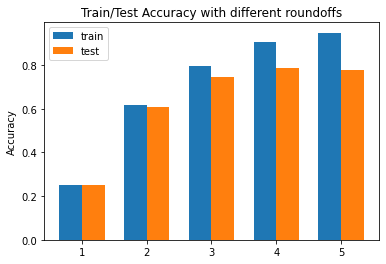

In [59]:
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
plt.title('Train/Test Accuracy with different roundoffs')
X_axis = np.arange(len(round_place))
ax.bar(X_axis - width/2,acc_tr,width,label='train')
ax.bar(X_axis + width/2,acc_ts,width,label='test')
plt.xticks(X_axis,round_place)
plt.ylabel('Accuracy')
plt.legend()
plt.show()

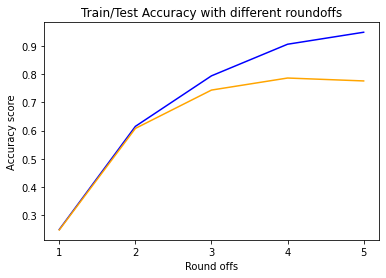

In [60]:
plt.title('Train/Test Accuracy with different roundoffs')
plt.plot(X_axis,acc_tr,color='b',label ='train')
plt.plot(X_axis,acc_ts,color='orange',label='test')
plt.xlabel('Round offs')
plt.ylabel('Accuracy score')
plt.xticks(range(len(round_place)),round_place)
plt.show()

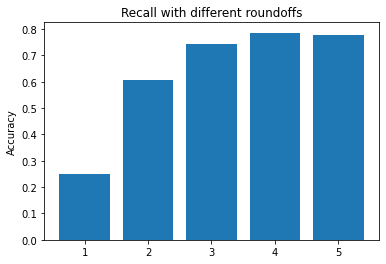

In [61]:
plt.bar(round_place,recall)
plt.title('Recall with different roundoffs')
plt.ylabel('Accuracy')
plt.show()